In [1]:
%matplotlib inline
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import git
import pathlib

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)
    
from libs.constants import model_seeds, error_seeds

In [4]:
model_type = "fashion-cnn2_1024"
model_seed = model_seeds[2]
model_instance = model_type + "-" + str(model_seed)
print(model_instance)

fashion-cnn2_1024-3824


In [5]:
error_seed = error_seeds[0]

In [6]:
ERR_TYPE_LIST = [0,2,3]
MAX_FAULT_PROB_LIST = [
                       #  1E-3, 2E-3, 5E-3, 
                       # 10E-3, 20E-3, 50E-3,
                      # 100E-3, 200E-3,  
                        500E-3,999E-3]
# Load dictionary
results_tag = 'fault_injection_analysis_results-fashion_cnn2--highERR--ERR0_ERR2_ERR3'
# results_tag = 'fault_injection_analysis_results-all_model_seeds--lowerror--' + model_arch

In [7]:
# ERR_TYPE_LIST = [2,3]
# MAX_FAULT_PROB_LIST = [100E-3, 200E-3, 500E-3, 999E-3]
# # Load dictionary
# results_tag = 'fault_injection_analysis_results-all_model_seeds--higherror--' + model_arch

In [8]:
results_folder = pathlib.Path(PROJ_ROOT_PATH / "notebooks" )
results_filename = results_tag + '.npy'
results_file = pathlib.Path(results_folder / results_filename )
result_dict = np.load(str(results_file), allow_pickle='TRUE').item()

In [9]:
original_acc = result_dict[model_seed]['original_acc']

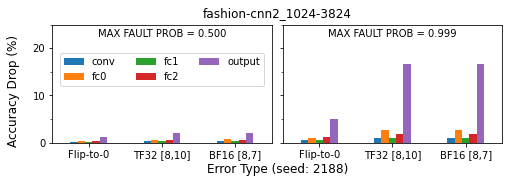

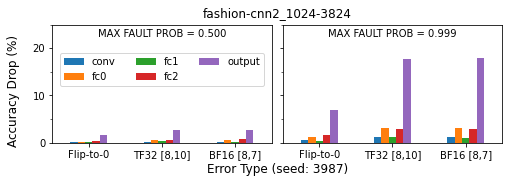

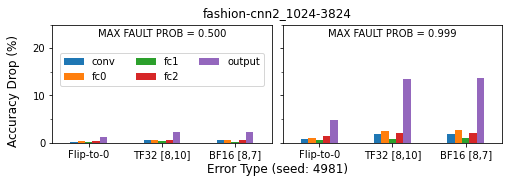

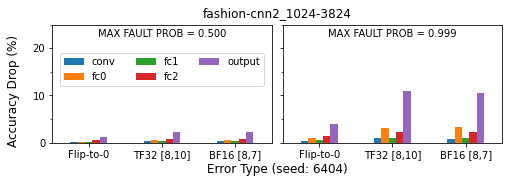

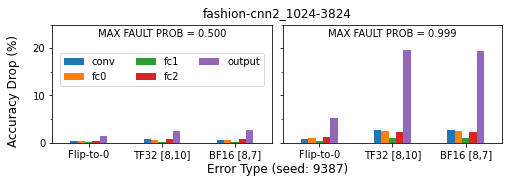

In [16]:
for error_seed in error_seeds:    
    # Plot figure
    fig_width = 3.125/0.8 * 2
    fig_height = fig_width / (1.618*2)
    n_rows = 1
    n_cols = 2
    fig, axs = plt.subplots(nrows=n_rows,
                            ncols=n_cols,
                            figsize=[fig_width,fig_height], # in inches
                            sharex=True,
                            sharey=True,
                            # constrained_layout=False, 
                            # tight_layout=True
                           )
    plt.subplots_adjust(left=0.1, bottom=0.2, right=None, top=None, wspace=0.05, hspace=0.1)

    for idx, MAX_FAULT_PROB in enumerate(MAX_FAULT_PROB_LIST):
        error_profile_tag = "LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}" + "-" +str(error_seed)

        faulty_accs = result_dict[model_seed][error_profile_tag]
        faulty_accs_sub = dict((k,faulty_accs[k]) for k in ERR_TYPE_LIST if k in faulty_accs)
        df = pd.DataFrame(faulty_accs_sub)
        df_inv = df.applymap(lambda value: original_acc-value).transpose()

        col = idx%n_cols

        df_inv.plot(kind="bar", ax=axs[col] )
        axs[col].get_legend().remove()
        axs[col].set_ylim([0.0, 0.25])
        axs[col].text(0.5, 0.92, 
                           "MAX FAULT PROB = " +  f"{MAX_FAULT_PROB:0.3f}", 
                           horizontalalignment='center', 
                           verticalalignment='center', 
                           transform=axs[col].transAxes)

        yticks = [0.0,0.1,0.2]
        axs[col].set_yticks(yticks,
                                 labels = [f"{int(tick*1E2):01d}" for tick in yticks]) 

        xticks = [0,1,2]
        axs[col].set_xticks(xticks,
                                 labels = ["Flip-to-0", "TF32 [8,10]", "BF16 [8,7]"],
                                           rotation=0) 


    axs[0].legend(labels=["conv", "fc0", "fc1", "fc2", "output", "ALL"],
                     loc='upper center', 
                     bbox_to_anchor=(0.5, 0.8),
                     ncol=3)
    fig.supxlabel('Error Type (seed: ' + str(error_seed) +')');
    fig.supylabel('Accuracy Drop (%)');
    fig.suptitle(model_instance)